# Malware Classification Project
## Project McNulty - Hasan Haq

In [90]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
from sklearn.learning_curve import learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import OneClassSVM
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.ensemble import ExtraTreesClassifier
from matplotlib.colors import ListedColormap
from matplotlib.colorbar import ColorbarBase
%matplotlib inline

### Read the data and clean it up

In [2]:
df = pd.read_csv('43/43_train.csv')

In [3]:
def label(df_in):
    labels = {'background': 'normal', 'normal': 'normal', 'botnet': 'botnet'}
    new_label = []
    for i in tqdm(df_in['Label']):
        if 'botnet' in i.lower():
            new_label.append('botnet')
        else:
            new_label.append('normal')
    df_in['Label'] = new_label
    return df_in

In [4]:
df = df.drop(['SIntPkt'], axis=1)
df = label(df)

100%|██████████| 1808122/1808122 [00:01<00:00, 1012351.19it/s]


In [5]:
def clean(df_in):
    df_new = df_in.copy(deep=True)
    
    # Big assumptions here... so far all the test sets fit it...
    #   Cuts total data from 1.8mm to 200k, and keeps all malware data
#     df_new = df_in.loc[df_in['sHops'] == 1]
#     df_new = df_in.loc[df_in['sTtl'] == 127]
    df_new['Load'] = df_in['Load'].map(lambda x: 1 if x>0 else 0)

    # Another assumption, that the ports, state and protocol that Neris uses here will be used in future test sets
    #  Cuts it down even further, down to 150k
    ports = df_in.loc[df_in['Label'] == "botnet"]['Dport'].unique()
    states = df_in.loc[df_in['Label'] == "botnet"]['State'].unique()
    protos = df_in.loc[df_in['Label'] == "botnet"]['Proto'].unique()

    df_new = df_new.loc[(df_new['Dport'].isin(ports)) & (df_new['State'].isin(states)) & (df_new['Proto'].isin(protos))]
    df_new['TotBytes'] = df_new['TotBytes'].astype('float64')
    df_new['TotPkts'] = df_new['TotPkts'].astype('float64')
    
    # Clean up direction labels before dummying
    df_new['Dir'] = df_new['Dir'].map(lambda x: "<->" if x=="  <->" else x)
    df_new['Dir'] = df_new['Dir'].map(lambda x: "->" if x=="   ->" else x)
    df_new['Dir'] = df_new['Dir'].map(lambda x: "<->" if x=="  <?>" else x)
    df_new['Dir'] = df_new['Dir'].map(lambda x: "<-" if x=="  <-" else x)
    df_new['Dir'] = df_new['Dir'].map(lambda x: "->" if x=="   ?>" else x)
    print(pd.isnull(df_new).any())
    return df_new

def clean_for_orig(df_in):
    _y = df_in['Label']
    X = df_in.drop(['StartTime', 'SrcAddr', 'Sport', 'DstAddr', 'Label'], axis=1) # Cols we def won't need
    X = X[['sMaxPktSz', 'pLoss', 'Dur', 'sMeanPktSz', 'TotBytes', 'TotAppByte', 'State', 'sHops', 'sTtl']]
#     X = X.drop(['TcpOpt', 'SrcBytes', 'Load', 'SrcJitter', 'PCRatio', 'TotPkts'], axis=1) # Cols we might need
    X_dum = pd.get_dummies(X, drop_first=True, columns=['State']) # Make dummies
    X_new = X_dum[['sMaxPktSz', 'pLoss', 'State_REQ', 'Dur', 'sMeanPktSz', 'TotBytes', 'TotAppByte', 'sHops', 'sTtl']] # Selected based on Rand Forest Feature Selection
    X_new = X_new.fillna(X_new.mean())
    print(pd.isnull(X_new).any())
    return X_new, _y

In [6]:
df_clean = clean(df)
df_clean.info()

StartTime     False
Dur           False
Proto         False
SrcAddr       False
Sport         False
Dir           False
DstAddr       False
Dport         False
State         False
TotPkts       False
TotBytes      False
sMaxPktSz      True
sMinPktSz      True
sMeanPktSz    False
SrcBytes      False
TotAppByte    False
TcpOpt         True
sTtl           True
sHops          True
pLoss         False
Load          False
SrcJitter      True
PCRatio       False
Label         False
dtype: bool
<class 'pandas.core.frame.DataFrame'>
Int64Index: 901968 entries, 0 to 1808120
Data columns (total 24 columns):
StartTime     901968 non-null object
Dur           901968 non-null float64
Proto         901968 non-null object
SrcAddr       901968 non-null object
Sport         901968 non-null object
Dir           901968 non-null object
DstAddr       901968 non-null object
Dport         901968 non-null object
State         901968 non-null object
TotPkts       901968 non-null float64
TotBytes      901968 non

In [7]:
X_for, y = clean_for_orig(df_clean)

sMaxPktSz     False
pLoss         False
State_REQ     False
Dur           False
sMeanPktSz    False
TotBytes      False
TotAppByte    False
sHops         False
sTtl          False
dtype: bool


In [79]:
X_for.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 901968 entries, 0 to 1808120
Data columns (total 9 columns):
sMaxPktSz     901968 non-null float64
pLoss         901968 non-null float64
State_REQ     901968 non-null float64
Dur           901968 non-null float64
sMeanPktSz    901968 non-null float64
TotBytes      901968 non-null float64
TotAppByte    901968 non-null int64
sHops         901968 non-null float64
sTtl          901968 non-null float64
dtypes: float64(8), int64(1)
memory usage: 68.8 MB


### Make Normal-Only DataFrame for OneClassSVM

In [72]:
df_norm = X_for.join(y)

In [74]:
X_norm = df_norm[df_norm['Label']=='normal'].drop(['Label'], axis=1)

### Train-Test-Split for Cross Validation on Train Set

In [9]:
y_bin = [0 if i == 'normal' else 1 for i in y]

In [60]:
sum(y_bin)

20941

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X_for, y_bin, test_size=0.3, stratify=y_bin)

### Standardize the Data

In [87]:
std_scale = StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)
X_norm_std = std_scale.transform(X_norm)

### Cross-Validation with Classification Algorithms

In [56]:
%%timeit -n1 -r1
# LinearSVM
svm = LinearSVC()
svm_acc = cross_val_score(svm, X_train_std, y_train, cv=10, scoring="f1")
print(svm_acc)

[ 0.82523901  0.81814657  0.84082254  0.81646787  0.82140108  0.82766527
  0.82876712  0.84583175  0.81533101  0.81712062]
1 loop, best of 1: 8min 31s per loop


In [57]:
%%timeit -n1 -r1
# Logistic Regression
logreg = LogisticRegression()
log_acc = cross_val_score(logreg, X_train_std, y_train, cv=10, scoring="f1")
print(log_acc)

[ 0.81384615  0.81418658  0.82869134  0.81333844  0.80724749  0.81552652
  0.81741788  0.83116883  0.80108569  0.80517444]
1 loop, best of 1: 44.7 s per loop


In [58]:
%%timeit -n1 -r1
# Gaussian Naive Bayes
gauss = GaussianNB()
gauss_acc = cross_val_score(gauss, X_train, y_train, cv=10, scoring='f1')
print(gauss_acc)

[ 0.04661847  0.04670736  0.04688482  0.04686922  0.04666004  0.04670811
  0.04672852  0.04676957  0.04664742  0.04676692]
1 loop, best of 1: 9.75 s per loop


In [59]:
%%timeit -n1 -r1
# Random Forests
forest = RandomForestClassifier()
forest_acc = cross_val_score(forest, X_train, y_train, cv=10, scoring='f1')
print(forest_acc)

[ 0.96733843  0.96707106  0.96969697  0.95885635  0.96386379  0.96776454
  0.96161898  0.96626087  0.96047569  0.96304045]
1 loop, best of 1: 1min 45s per loop


In [ ]:
%%timeit -n1 -r1
# OneClassSVM
svm = OneClassSVM()
svm_acc = cross_val_score(svm, X_train_std, cv=10, scoring='f1')
print(svm_acc)

### Begin Charts

In [14]:
def fig_format(x, y):
    fig = plt.figure()
    fig.set_size_inches(x, y, forward=True)
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelcolor='white',
        labelsize=12,
        labelbottom='on') # labels along the bottom edge are off
    plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        labelcolor='white',
        labelsize=12,
        right='off')         # ticks along the top edge are off
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    fig.patch.set_alpha(0.0)
    return fig

def ax_format(fig, ylabel, xlabel=None):
    ax = fig.add_subplot(111)
    ax.patch.set_alpha(0.0)
    ax.spines['bottom'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.set_ylabel(ylabel, color='white', weight='bold', size=12)
    if xlabel != None:
        ax.set_xlabel(xlabel, color='white', weight='bold', size=12)
    return ax

### Hexbin Data Plot

In [54]:
df_hex = df_clean[(df_clean['TotBytes']<=500) & (df_clean['sMaxPktSz']<=200)]

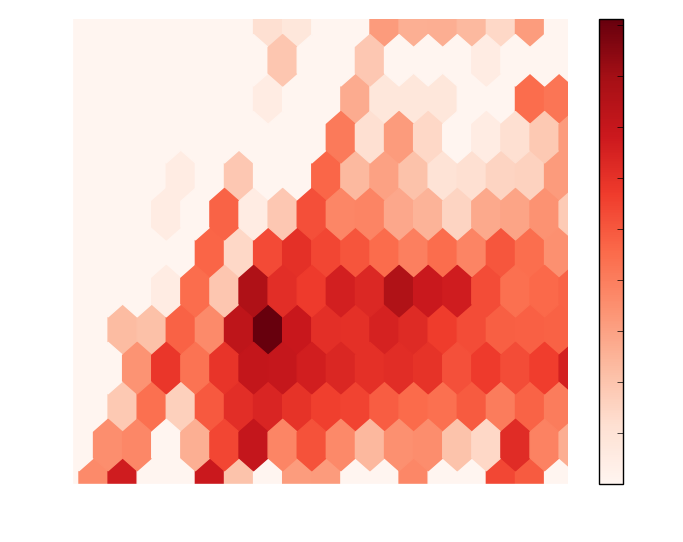

In [55]:
fig = fig_format(8, 6)
ax = ax_format(fig, 'TotBytes', 'sMaxPktSz')

hexplot = ax.hexbin(df_hex['TotBytes'], df_hex['sMaxPktSz'], reduce_C_function='mean', cmap='Reds', gridsize=25, bins='log')
plt.ylim([60, 120])
plt.xlim([100, 400])
cb = fig.colorbar(hexplot, ax=ax)
cb.set_label('log10(N)', color='white', weight='bold')
cbytick_obj = plt.getp(cb.ax.axes, 'yticklabels')
plt.setp(cbytick_obj, color='white', weight='bold');

### Random Forests: Feature Importances

Feature ranking:
1. feature 2 (0.206176)
2. feature 0 (0.205293)
3. feature 1 (0.144055)
4. feature 7 (0.126669)
5. feature 4 (0.105366)
6. feature 3 (0.065708)
7. feature 5 (0.053184)
8. feature 6 (0.053132)
9. feature 8 (0.040416)
1 loop, best of 1: 12.6 s per loop


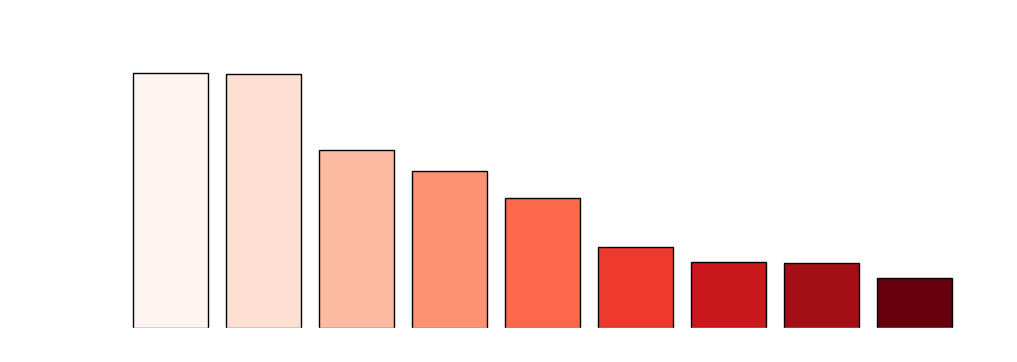

In [17]:
%%timeit -n1 -r1
forest = RandomForestClassifier(random_state=100)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

labs = []
for _ in indices:
    labs.append(X_train.columns[_])

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    
# Plot the feature importances of the forest

fig = fig_format(12, 4)
ax = ax_format(fig, "Feature Importance")
ax.bar(range(X_train.shape[1]), importances[indices], align="center", color=plt.cm.Reds(np.linspace(0,1,9)))
plt.xticks(range(X_train.shape[1]), labs)
# plt.ylim([0, .5])
# plt.title("Feature importances")
# plt.xlim([-1, X_train.shape[1]])

### ROC Curve

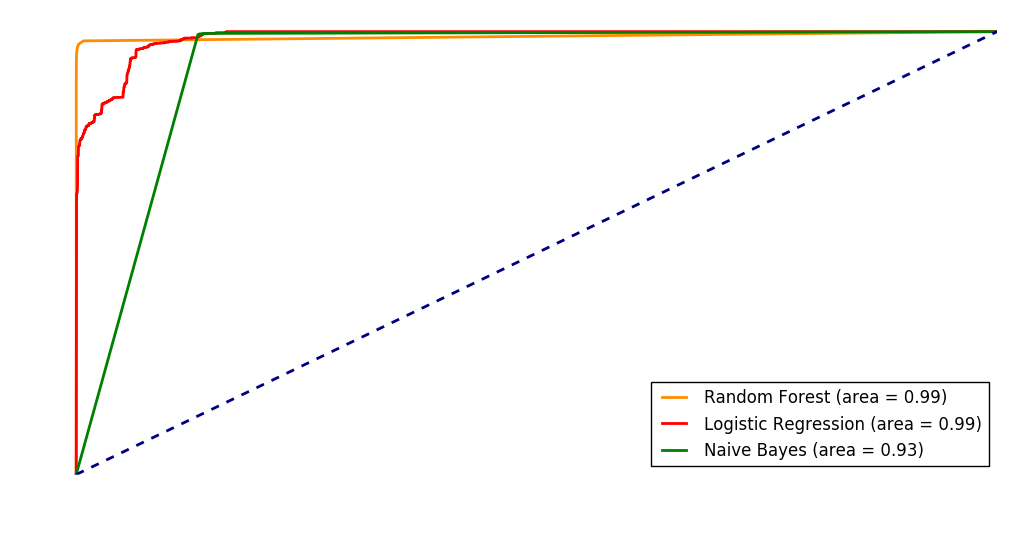

In [49]:
n_classes = 2

# Logistic
log_class = LogisticRegression(class_weight={1:20})
y_log = log_class.fit(X_train_std, y_train).predict_proba(X_test_std)[:,1]

fpr_log, tpr_log, _ = roc_curve(y_test, y_log)
roc_log = auc(fpr_log, tpr_log)

# Random Forest
for_class = RandomForestClassifier()
y_for = for_class.fit(X_train, y_train).predict_proba(X_test)[:,1]

fpr_for, tpr_for, _ = roc_curve(y_test, y_for)
roc_for = auc(fpr_for, tpr_for)

# GaussianNB
nb_class = GaussianNB()
y_nb = nb_class.fit(X_train_std, y_train).predict_proba(X_test_std)[:,1]

fpr_nb, tpr_nb, _ = roc_curve(y_test, y_nb)
roc_nb = auc(fpr_nb, tpr_nb)

# Plot the graphs
fig = fig_format(12, 6)
ax = ax_format(fig, 'True Positive Rate', 'False Positive Rate')
ax.plot(fpr_for, tpr_for, color='darkorange',
         lw=2, label='Random Forest (area = %0.2f)' % roc_for)
ax.plot(fpr_log, tpr_log, color='red',
         lw=2, label='Logistic Regression (area = %0.2f)' % roc_log)
ax.plot(fpr_nb, tpr_nb, color='green',
         lw=2, label='Naive Bayes (area = %0.2f)' % roc_nb)
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-.01, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.show()

## Test Set (Cross Validation)

### Random Forests

In [18]:
forest = RandomForestClassifier()
forest.fit(X_train,y_train)
ypred_for = forest.predict(X_test)

In [19]:
print("accuracy: ", accuracy_score(y_test, ypred_for))
print("precision: ", precision_score(y_test, ypred_for))
print("recall: ", recall_score(y_test, ypred_for))
print("f1 score: ", f1_score(y_test, ypred_for))

accuracy:  0.998351755971
precision:  0.985201197207
recall:  0.943170964661
f1 score:  0.96372804164


###  Logistic Regression

In [121]:
logreg = LogisticRegression()
logreg.fit(X_train_std,y_train)
ypred_log = logreg.predict(X_test_std)

In [122]:
print("accuracy: ", accuracy_score(y_test, ypred_log))
print("precision: ", precision_score(y_test, ypred_log))
print("recall: ", recall_score(y_test, ypred_log))
print("f1 score: ", f1_score(y_test, ypred_log))

accuracy:  0.992494207124
precision:  0.939062177236
recall:  0.723654886979
f1 score:  0.817405376247


### LinearSVM

In [124]:
svmreg = LinearSVC()
svmreg.fit(X_train_std,y_train)
ypred_svm = svmreg.predict(X_test_std)

In [125]:
print("accuracy: ", accuracy_score(y_test, ypred_svm))
print("precision: ", precision_score(y_test, ypred_svm))
print("recall: ", recall_score(y_test, ypred_svm))
print("f1 score: ", f1_score(y_test, ypred_svm))

accuracy:  0.992734422061
precision:  0.952031839129
recall:  0.723495702006
f1 score:  0.822178002894


## New Sample

### Read the data and clean it up

In [21]:
df_50 = pd.read_csv('50/test_50.csv')

In [22]:
df_50 = label(df_50)

100%|██████████| 2087508/2087508 [00:02<00:00, 922642.42it/s] 


In [23]:
def clean_bot(df_in):
    df_in = df_in.drop(['SIntPkt'], axis=1)
    df_new = df_in.copy(deep=True)
    
#     df_new = df_in.loc[df_in['sHops'] == 1]
#     df_new = df_in.loc[df_in['sTtl'] == 127]
    df_new['Load'] = df_in['Load'].map(lambda x: 1 if x>0 else 0)

    df_new['TotBytes'] = df_new['TotBytes'].astype('float64')
    df_new['TotPkts'] = df_new['TotPkts'].astype('float64')
    print(pd.isnull(df_new).any())
    return df_new

def clean_for_bot(df_in):
    df_in = df_in.dropna(subset=['sMaxPktSz'])
    _y = df_in['Label']
    X = df_in.drop(['StartTime', 'SrcAddr', 'Sport', 'DstAddr', 'Label'], axis=1) # Cols we def won't need
    X = X.drop(['Dir', 'TcpOpt', 'SrcBytes', 'Load', 'SrcJitter', 'PCRatio', 'TotPkts'], axis=1) # Cols we might need
    X_dum = pd.get_dummies(X, drop_first=True, columns=['Proto', 'Dport', 'State']) # Make dummies
    X_new = X_dum[['sMaxPktSz', 'pLoss', 'State_REQ', 'Dur', 'sMeanPktSz', 'TotBytes', 'TotAppByte', 'sHops', 'sTtl']] # Selected based on Rand Forest Feature Selection
    X_new = X_new.fillna(X_new.mean())
    print(pd.isnull(X_new).any())
    return X_new, _y

In [24]:
df_50['Label'].value_counts()

normal    1902521
botnet     184987
Name: Label, dtype: int64

In [25]:
df_50_clean = clean(df_50)

StartTime     False
Dur           False
Proto         False
SrcAddr       False
Sport         False
Dir           False
DstAddr       False
Dport         False
State         False
TotPkts       False
TotBytes      False
sMaxPktSz      True
sMinPktSz      True
sMeanPktSz    False
SrcBytes      False
TotAppByte    False
TcpOpt         True
sTtl           True
sHops          True
pLoss         False
Load          False
SrcJitter      True
PCRatio       False
Label         False
dtype: bool


In [26]:
df_50_clean['Label'].value_counts()

normal    1097959
botnet     184987
Name: Label, dtype: int64

In [27]:
X_50, y_50 = clean_for_bot(df_50_clean)

sMaxPktSz     False
pLoss         False
State_REQ     False
Dur           False
sMeanPktSz    False
TotBytes      False
TotAppByte    False
sHops         False
sTtl          False
dtype: bool


In [28]:
len(X_50)

1282558

In [29]:
y50_bin = [0 if i == 'normal' else 1 for i in y_50]

In [30]:
sum(y50_bin)/len(y50_bin)

0.1442328534070194

In [31]:
X_50.columns

Index(['sMaxPktSz', 'pLoss', 'State_REQ', 'Dur', 'sMeanPktSz', 'TotBytes',
       'TotAppByte', 'sHops', 'sTtl'],
      dtype='object')

In [32]:
X_for.columns

Index(['sMaxPktSz', 'pLoss', 'State_REQ', 'Dur', 'sMeanPktSz', 'TotBytes',
       'TotAppByte', 'sHops', 'sTtl'],
      dtype='object')

### Random Forests 

In [33]:
forest_50 = RandomForestClassifier()
forest_50.fit(X_for,y_bin)
# ypred_prob = forest.predict_proba(X_50)
ypred_50 = forest_50.predict(X_50)

In [34]:
print("Accuracy: ", accuracy_score(y50_bin, ypred_50))
print("Precision: ", precision_score(y50_bin, ypred_50))
print("Recall: ", recall_score(y50_bin, ypred_50))
print("F1: ", f1_score(y50_bin, ypred_50))

Accuracy:  0.906252192883
Precision:  0.989521591871
Recall:  0.353770805516
F1:  0.521202757215


### Logistic Regression 

In [132]:
logreg_50 = LogisticRegression(class_weight={1: 50})
logreg_50.fit(std_scale.transform(X_for),y_bin)
ypred_50_log = logreg_50.predict(std_scale.transform(X_50))

In [133]:
print("Accuracy: ", accuracy_score(y50_bin, ypred_50_log))
print("Precision: ", precision_score(y50_bin, ypred_50_log))
print("Recall: ", recall_score(y50_bin, ypred_50_log))
print("F1: ", f1_score(y50_bin, ypred_50_log))

Accuracy:  0.884258645613
Precision:  0.555383785291
Recall:  0.990447977425
F1:  0.711692902299


### LinearSVC

In [40]:
linsvc_50 = LinearSVC(class_weight={1:50})
linsvc_50.fit(std_scale.transform(X_for), y_bin)
ypred_50_linsvc = linsvc_50.predict(std_scale.transform(X_50))

In [44]:
print("Accuracy: ", accuracy_score(y50_bin, ypred_50_linsvc))
print("Precision: ", precision_score(y50_bin, ypred_50_linsvc))
print("Recall: ", recall_score(y50_bin, ypred_50_linsvc))
print("F1: ", f1_score(y50_bin, ypred_50_linsvc))

Accuracy:  0.891019353511
Precision:  0.571122947545
Recall:  0.981323011887
F1:  0.722029759087


### Pickle

In [45]:
with open('live/forest_ttl.pkl', 'wb') as f:
    pickle.dump(forest_50, f, protocol=pickle.HIGHEST_PROTOCOL)

In [46]:
with open('live/logit_ttl.pkl', 'wb') as f:
    pickle.dump(logreg_50, f, protocol=pickle.HIGHEST_PROTOCOL)

In [47]:
with open('live/svc_ttl.pkl', 'wb') as f:
    pickle.dump(linsvc_50, f, protocol=pickle.HIGHEST_PROTOCOL)

In [48]:
with open('live/scale_ttl.pkl', 'wb') as f:
    pickle.dump(std_scale, f, protocol=pickle.HIGHEST_PROTOCOL)

In [349]:
X_train

,sMaxPktSz,pLoss,State_REQ,Dur,sMeanPktSz,TotBytes,TotAppByte
1115822,749.0,0.000000,0.0,0.308284,175.833328,1803.0,1207
143000,81.0,0.000000,0.0,0.004517,81.000000,565.0,481
1329484,84.0,0.000000,0.0,0.000444,84.000000,261.0,177
1612367,419.0,0.000000,0.0,0.005326,105.125000,8738.0,7703
1502994,767.0,0.000000,0.0,0.453184,283.571442,2941.0,2369
505998,1514.0,0.000000,0.0,0.400014,434.166656,3574.0,2920
1724554,75.0,0.000000,0.0,0.000256,75.000000,227.0,143
1733549,76.0,0.000000,0.0,0.022369,76.000000,201.0,117
1597023,73.0,0.000000,0.0,0.000302,73.000000,309.0,225
305304,76.0,0.000000,0.0,0.000208,76.000000,209.0,125


In [350]:
X_test

,sMaxPktSz,pLoss,State_REQ,Dur,sMeanPktSz,TotBytes,TotAppByte
502209,72.0,0.000000,0.0,0.102912,72.000000,345.0,261
319571,70.0,0.000000,0.0,0.002252,70.000000,215.0,131
21136,846.0,0.000000,0.0,6.314375,145.733337,19537.0,17593
1433253,74.0,0.000000,0.0,0.131715,74.000000,490.0,406
660605,679.0,0.000000,0.0,5.822789,214.625000,7711.0,6775
1767710,654.0,0.000000,0.0,1.899540,133.791672,65538.0,61716
52913,72.0,0.000000,0.0,0.020633,72.000000,390.0,306
1473505,1173.0,4.166667,0.0,3.052510,172.500000,15283.0,13951
1549966,72.0,0.000000,0.0,0.000496,72.000000,236.0,152
465747,62.0,45.454545,1.0,136.017487,62.000000,372.0,0
